# Simulating transmission with Rayleigh and AWGN channels and different constellation sizes

This notebook illustrates how to perform a simulation of a transmission through Rayleigh channel using different modulations. 

This is a modification of the [Transmission_with_AWGN_channel](Transmission_with_AWGN_channel.ipynb) notebook.

In [8]:
%matplotlib inline

import math

import numpy as np
from matplotlib import pyplot as plt

from pyphysim.modulators.fundamental import BPSK, QAM, Modulator
from pyphysim.simulations import Result, SimulationResults, SimulationRunner
from pyphysim.util.conversion import dB2Linear, linear2dB
from pyphysim.util.misc import pretty_time, randn_c, count_bit_errors

np.set_printoptions(precision=2, linewidth=120)

# Visualize the constellation

First let's visualize the different constellations that will be employed.

For $M=2$ BPSK modulation will be used, with symbols being $-1$ and $1$. For other sizes QAM modulation will be used.

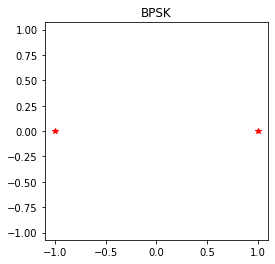

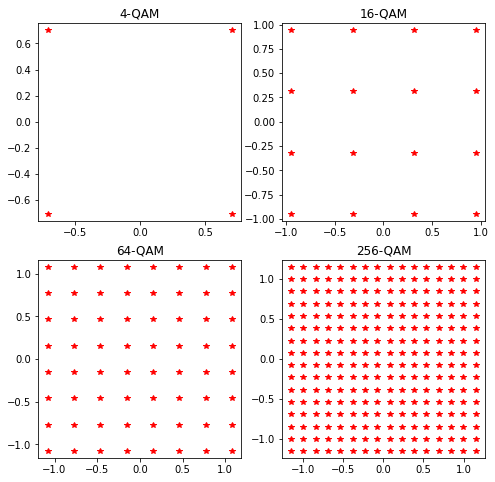

In [9]:
bpsk = BPSK()
qam4 = QAM(4)
qam16 = QAM(16)
qam64 = QAM(64)
qam256 = QAM(256)

fig_bpsk, ax_bpsk = plt.subplots(figsize=(4, 4))
ax_bpsk.set_title("BPSK")
ax_bpsk.plot(bpsk.symbols.real, bpsk.symbols.imag, "*r", label="4-QAM")
ax_bpsk.axis("equal")

fig, [[ax11, ax12], [ax21, ax22]] = plt.subplots(figsize=(8, 8),
                                                 nrows=2,
                                                 ncols=2)

ax11.set_title("4-QAM")
ax11.plot(qam4.symbols.real, qam4.symbols.imag, "*r", label="4-QAM")
ax11.axis("equal")

ax12.set_title("16-QAM")
ax12.plot(qam16.symbols.real, qam16.symbols.imag, "*r", label="16-QPSK")
ax12.axis("equal")

ax21.set_title("64-QAM")
ax21.plot(qam64.symbols.real, qam64.symbols.imag, "*r", label="64-QAM")
ax21.axis("equal")

ax22.set_title("256-QAM")
ax22.plot(qam256.symbols.real, qam256.symbols.imag, "*r", label="256-QAM")
ax22.axis("equal");

# Implement a simulator

In this notebook we will use the `run_in_parallel` method to run the simulation, which **requires our simulator to be importable**. For that, we add the code in the cell below and used the `%%writefile` cell magic to save the content of the cell to a file. The cell content is **NOT executed**. After that, we can import from the file.

In [10]:
%%writefile rayleigh_qam_simulator.py

import math

import numpy as np

from pyphysim.modulators.fundamental import BPSK, QAM, Modulator
from pyphysim.simulations import Result, SimulationResults, SimulationRunner
from pyphysim.util.conversion import dB2Linear
from pyphysim.util.misc import randn_c, count_bit_errors


class RayleighOrAwgnSimulator(SimulationRunner):

    def __init__(self, SINR_dB_values, simulate_with_rayleigh=False):
        # If simulate_with_rayleigh is false only AWGN is used
        super().__init__()

        self._simulate_with_rayleigh = simulate_with_rayleigh

        # Add the simulation parameters to the `params` attribute.
        self.params.add('EbN0_db', SINR_dB_values)
        self.params.set_unpack_parameter('EbN0_db')

        # Note that when M=2 BPSK modulation will be used, while other values will use QAM
        self.params.add("M", [2, 4, 16, 64, 256])
        self.params.set_unpack_parameter('M')

        # Number of times the `_run_simulation` method will run when `simulate` method is called.
        # We are using a value 100 times larger than before, but the simulation will not take
        # 100 times the previous elapsed time to finish thanks to the implementation of the
        # `_keep_going` method that will allow us to skip many of these iterations for low EbN0 values
        self.rep_max = 50000

        # Number of symbols generated for this realization
        self.num_symbols = 1000

        # Used in the implementation of `_keep_going` method. This is the maximum numbers of symbol
        # errors we allow before `_run_simulation` is stoped for a given configuration
        self.max_symbol_errors = 1. / 300. * self.num_symbols * self.rep_max

        # Set a nice message for the progressbar
        self.progressbar_message = f"Simulating for {self.params.get_num_unpacked_variations()} configurations"

        self.update_progress_function_style = "text1"  # "ipython"

    def _keep_going(self, current_params, current_sim_results, current_rep):
        # Note that we have added a "symbol_errors" result in `_run_simulation` to use here

        # Get the last value in the "symbol_errors" results list, which corresponds to the current configuration
        cumulated_symbol_errors \
            = current_sim_results['symbol_errors'][-1].get_result()
        return cumulated_symbol_errors < self.max_symbol_errors

    def _run_simulation(self, current_parameters):
        # Since EbN0_db is an "unpacked parameter" a single value is passed to `_run_simulation`.
        # We can get the current value as below
        sinr_dB = current_parameters['EbN0_db']
        M = current_parameters['M']

        modulator = BPSK() if M == 2 else QAM(M)

        # Find the noise power from the EbN0 value (in dB)
        EbN0_linear = dB2Linear(sinr_dB)
        snr_linear = EbN0_linear * math.log2(M)
        noise_power = 1 / snr_linear

        # Generate random transmit data and modulate it
        data = np.random.randint(0, modulator.M, size=self.num_symbols)
        modulated_data = modulator.modulate(data)

        # Noise vector
        n = math.sqrt(noise_power) * randn_c(self.num_symbols)

        if self._simulate_with_rayleigh:
            # Rayleigh channel
            h = randn_c(modulated_data.size)

            # Receive the corrupted data
            received_data = h * modulated_data + n

            # Equalization
            received_data /= h

        else:
            # Receive the corrupted data
            received_data = modulated_data + n

        # Demodulate the received data and compute the number of symbol errors
        demodulated_data = modulator.demodulate(received_data)
        symbol_errors = sum(demodulated_data != data)

        num_bit_errors = count_bit_errors(data, demodulated_data)

        # Create a SimulationResults object and save the symbol error rate.
        # Note that the symbol error rate is given by the number of symbol errors divided by the number of
        # transmited symbols. We want to combine the symbol error rate for the many calls of `_run_simulation`.
        # Thus, we choose `Result.RATIOTYPE` as the "update_type". See the documentation of the `Result` class
        # for more about it.
        simResults = SimulationResults()
        simResults.add_new_result("symbol_error_rate",
                                  Result.RATIOTYPE,
                                  value=symbol_errors,
                                  total=self.num_symbols)
        simResults.add_new_result("symbol_errors",
                                  Result.SUMTYPE,
                                  value=symbol_errors)
        simResults.add_new_result("num_bit_errors",
                                  Result.SUMTYPE,
                                  value=num_bit_errors)
        simResults.add_new_result("bit_error_rate",
                                  Result.RATIOTYPE,
                                  value=num_bit_errors,
                                  total=int(np.log2(modulator.M)) * data.size)
        return simResults

Overwriting rayleigh_qam_simulator.py


# Running the simulation

Now we import the simulator

In [11]:
from rayleigh_qam_simulator import RayleighOrAwgnSimulator

Now we can run the simulation. Let's create an `RayleighSimulator` object and check its parameters.
First let's create a `Client` and get a `view` such that we can run the simulation in parallel.

<span style="color:red;">Remember to start the engines with the `ipcluster start` command</span>

In [12]:
from ipyparallel import Client
import sys
import os

c = Client()
dview = c.direct_view()
dview.execute('%reset')
dview.execute('import sys')
dview.execute('sys.path.append("{0}")'.format(os.getcwd()), block=True)

lview = c.load_balanced_view()
# view.apply_sync?

In [13]:
EbN0_db_rayleigh = np.linspace(-5, 30, 8)

runner_rayleigh = RayleighOrAwgnSimulator(EbN0_db_rayleigh,
                                          simulate_with_rayleigh=True)
runner_rayleigh.set_results_filename("qam_rayleigh")
print("Simulation parameters:", runner_rayleigh.params)

runner_rayleigh.simulate_in_parallel(lview)
# runner_rayleigh.simulate()
print(runner_rayleigh.elapsed_time)

Simulation parameters: {'EbN0_db*': [-5.  0.  5. 10. 15. 20. 25. 30.], 'M*': [2, 4, 16, 64, 256]}
-------- Simulating for 40 configurations -------1
    1    2    3    4    5    6    7    8    9    0
----0----0----0----0----0----0----0----0----0----0
**************************************************
0.21s


In [14]:
EbN0_db_awgn = np.linspace(-5, 30, 8)

runner_awgn = RayleighOrAwgnSimulator(EbN0_db_awgn,
                                      simulate_with_rayleigh=False)
runner_awgn.set_results_filename("qam_awgn")
print("Simulation parameters:", runner_awgn.params)

runner_awgn.simulate_in_parallel(lview)
# runner_awgn.simulate()
print(runner_awgn.elapsed_time)

Simulation parameters: {'EbN0_db*': [-5.  0.  5. 10. 15. 20. 25. 30.], 'M*': [2, 4, 16, 64, 256]}
-------- Simulating for 40 configurations -------1
    1    2    3    4    5    6    7    8    9    0
----0----0----0----0----0----0----0----0----0----0
**************************************************
1m:46s


# Visualizing the results

To get the obtained results we can use the `runner.results.get_result_values_list` as before. However, since we have two parameters that were unpacked we will get the results of all possible combinations. We likely want to specify which subset we want. This can be done by passing the `fixed_params` argument to the `get_result_values_list` with a dictionary indicating the fixed values as below.

In [15]:
symbol_error_rate_bpsk_rayleigh = runner_rayleigh.results.get_result_values_list(
    "symbol_error_rate", fixed_params={"M": 2})
symbol_error_rate_qam4_rayleigh = runner_rayleigh.results.get_result_values_list(
    "symbol_error_rate", fixed_params={"M": 4})
symbol_error_rate_qam16_rayleigh = runner_rayleigh.results.get_result_values_list(
    "symbol_error_rate", fixed_params={"M": 16})
symbol_error_rate_qam64_rayleigh = runner_rayleigh.results.get_result_values_list(
    "symbol_error_rate", fixed_params={"M": 64})
symbol_error_rate_qam256_rayleigh = runner_rayleigh.results.get_result_values_list(
    "symbol_error_rate", fixed_params={"M": 256})

print("Symbol Errors Rayleigh Channel (BPSK):\n",
      symbol_error_rate_bpsk_rayleigh)
print("Symbol Errors Rayleigh Channel (4-QAM):\n",
      symbol_error_rate_qam4_rayleigh)
print("Symbol Errors Rayleigh Channel (16-QAM):\n",
      symbol_error_rate_qam16_rayleigh)
print("Symbol Errors Rayleigh Channel (64-QAM):\n",
      symbol_error_rate_qam64_rayleigh)
print("Symbol Errors Rayleigh Channel (256-QAM):\n",
      symbol_error_rate_qam256_rayleigh)

symbol_error_rate_bpsk_awgn = runner_awgn.results.get_result_values_list(
    "symbol_error_rate", fixed_params={"M": 2})
symbol_error_rate_qam4_awgn = runner_awgn.results.get_result_values_list(
    "symbol_error_rate", fixed_params={"M": 4})
symbol_error_rate_qam16_awgn = runner_awgn.results.get_result_values_list(
    "symbol_error_rate", fixed_params={"M": 16})
symbol_error_rate_qam64_awgn = runner_awgn.results.get_result_values_list(
    "symbol_error_rate", fixed_params={"M": 64})
symbol_error_rate_qam256_awgn = runner_awgn.results.get_result_values_list(
    "symbol_error_rate", fixed_params={"M": 256})

print("Symbol Errors AWGN Channel (BPSK):\n", symbol_error_rate_qam4_awgn)
print("Symbol Errors AWGN Channel (4-QAM):\n", symbol_error_rate_qam4_awgn)
print("Symbol Errors AWGN Channel (16-QAM):\n", symbol_error_rate_qam16_awgn)
print("Symbol Errors AWGN Channel (64-QAM):\n", symbol_error_rate_qam64_awgn)
print("Symbol Errors AWGN Channel (256-QAM):\n", symbol_error_rate_qam256_awgn)

Symbol Errors Rayleigh Channel (BPSK):
 [0.25516207951070335, 0.146170902716915, 0.06434542647626398, 0.023294019005030742, 0.0077153173170393, 0.00246898, 0.00078914, 0.00024696]
Symbol Errors Rayleigh Channel (4-QAM):
 [0.4333662337662338, 0.25825541795665635, 0.11560818307905686, 0.04209368686868687, 0.014022631667507992, 0.004495428186109238, 0.00143894, 0.00045966]
Symbol Errors Rayleigh Channel (16-QAM):
 [0.7337763157894737, 0.5501947194719472, 0.31336654135338343, 0.13441370967741936, 0.04792840713053479, 0.015926612517916865, 0.00508351125480388, 0.00161208]
Symbol Errors Rayleigh Channel (64-QAM):
 [0.8970967741935484, 0.790260663507109, 0.5848456140350877, 0.3274607843137255, 0.13740972794723824, 0.04893131787496331, 0.01593755976286097, 0.005132668144863267]
Symbol Errors Rayleigh Channel (256-QAM):
 [0.9652601156069364, 0.9211988950276243, 0.8152341463414634, 0.6036642599277978, 0.33553319919517105, 0.14043892165122157, 0.04960684523809524, 0.016222698072805138]
Symbol Err

Now we can finally see the plot and compare the simulated results with theoretical values.

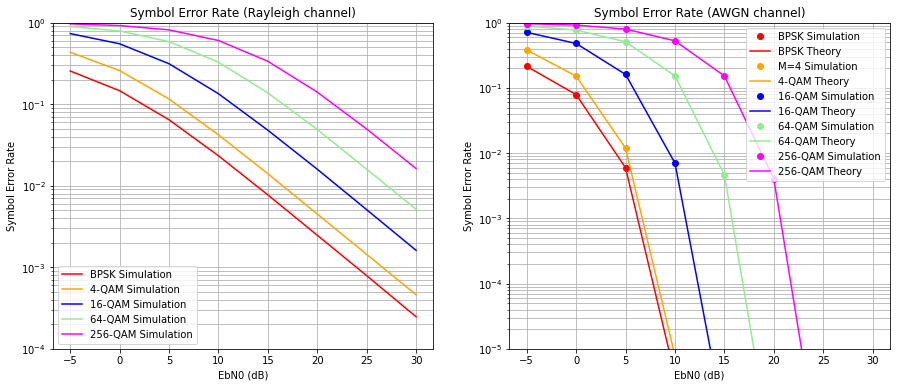

In [16]:
# Now let's plot the results
fig, [ax1, ax2] = plt.subplots(figsize=(15, 6), ncols=2)

ax1.semilogy(EbN0_db_rayleigh,
             symbol_error_rate_bpsk_rayleigh,
             "-",
             color="red",
             label="BPSK Simulation")
ax1.semilogy(EbN0_db_rayleigh,
             symbol_error_rate_qam4_rayleigh,
             "-",
             color="orange",
             label="4-QAM Simulation")
ax1.semilogy(EbN0_db_rayleigh,
             symbol_error_rate_qam16_rayleigh,
             "-",
             color="blue",
             label="16-QAM Simulation")
ax1.semilogy(EbN0_db_rayleigh,
             symbol_error_rate_qam64_rayleigh,
             "-",
             color="lightgreen",
             label="64-QAM Simulation")
ax1.semilogy(EbN0_db_rayleigh,
             symbol_error_rate_qam256_rayleigh,
             "-",
             color="magenta",
             label="256-QAM Simulation")
# ax1.semilogy(EbN0_db, QAM(256).calcTheoreticalSER(EbN0_db), color="magenta", label="M=256 Theory")
ax1.set_title("Symbol Error Rate (Rayleigh channel)")
ax1.set_ylabel("Symbol Error Rate")
ax1.set_xlabel("EbN0 (dB)")
ax1.grid(True, which="both")
ax1.set_ylim((1e-4, 1e0))
ax1.legend()

ax2.semilogy(EbN0_db_awgn,
             symbol_error_rate_bpsk_awgn,
             "o",
             color="red",
             label="BPSK Simulation")
ax2.semilogy(EbN0_db_awgn,
             BPSK().calcTheoreticalSER(EbN0_db_awgn),
             color="red",
             label="BPSK Theory")
ax2.semilogy(EbN0_db_awgn,
             symbol_error_rate_qam4_awgn,
             "o",
             color="orange",
             label="M=4 Simulation")
ax2.semilogy(EbN0_db_awgn,
             QAM(4).calcTheoreticalSER(EbN0_db_awgn + linear2dB(2)),
             color="orange",
             label="4-QAM Theory")
ax2.semilogy(EbN0_db_awgn,
             symbol_error_rate_qam16_awgn,
             "o",
             color="blue",
             label="16-QAM Simulation")
ax2.semilogy(EbN0_db_awgn,
             QAM(16).calcTheoreticalSER(EbN0_db_awgn + linear2dB(4)),
             color="blue",
             label="16-QAM Theory")
ax2.semilogy(EbN0_db_awgn,
             symbol_error_rate_qam64_awgn,
             "o",
             color="lightgreen",
             label="64-QAM Simulation")
ax2.semilogy(EbN0_db_awgn,
             QAM(64).calcTheoreticalSER(EbN0_db_awgn + linear2dB(6)),
             color="lightgreen",
             label="64-QAM Theory")
ax2.semilogy(EbN0_db_awgn,
             symbol_error_rate_qam256_awgn,
             "o",
             color="magenta",
             label="256-QAM Simulation")
ax2.semilogy(EbN0_db_awgn,
             QAM(256).calcTheoreticalSER(EbN0_db_awgn + linear2dB(8)),
             color="magenta",
             label="256-QAM Theory")
ax2.set_title("Symbol Error Rate (AWGN channel)")
ax2.set_ylabel("Symbol Error Rate")
ax2.set_xlabel("EbN0 (dB)")
ax2.grid(True, which="both")
ax2.set_ylim((1e-5, 1e0))
ax2.legend();

The results matches the theoretical values pretty well for AWGN channel.

See [this link for some derivations](http://www.dsplog.com/2012/01/01/symbol-error-rate-16qam-64qam-256qam/).
